In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 16384
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "codellama/CodeLlama-13b-Instruct-hf",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

/usr/local/lib/python3.10/dist-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/dist-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 07-14 14:01:54 [importing.py:53] Triton module has been replaced with a placeholder.
INFO 07-14 14:01:54 [__init__.py:239] Automatically detected platform cuda.


2025-07-14 14:01:56,048	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


==((====))==  Unsloth 2025.5.3: Fast Llama patching. Transformers: 4.51.3. vLLM: 0.8.5.
   \\   /|    Tesla V100-SXM2-32GB. Num GPUs = 1. Max memory: 31.749 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards: 100%|██████████| 3/3 [01:20<00:00, 26.97s/it]


codellama/CodeLlama-13b-Instruct-hf does not have a padding token! Will use pad_token = <unk>.


In [ ]:
from datasets import load_dataset

# Define the paths to your dataset files
data_files = {
    'train': 'severity_data_train.csv',
    'val': 'severity_data_val.csv',
    'test': 'severity_data_test.csv'
}

# Load the dataset
dataset = load_dataset('csv', data_files=data_files)

import random
from datasets import concatenate_datasets, DatasetDict

random.seed(42)

SYSTEM_PROMPT = [
    """You are the smartest AI solidity smart contract security auditor in the world that only answer in one word between "low", "medium" or "high".""",
]

PROMPTS = [
    """You need to analyze the given vulnerability explanation and classify the severity of it as "low", "medium" or "high" based on the impact of that vulnerability. Dont give any additional explanations just give the label (low, medium or high).
    
    This is the vulnerability explanation we need to analyze:
    {explanation}
    
Answer: """,
]

def make_conversational_vote(examples, system_prompt, prompt):
    explanation = examples['vuln_explanation']
    severity = examples['severity']
    selected_system_prompt = system_prompt
    selected_user_prompt = prompt
    conversation = [{"role": "system", "content": selected_system_prompt}, 
                    {"role": "user", "content": selected_user_prompt.format(explanation=explanation)}]
    
    return { "conversations" : conversation, 'label': severity}

# Generate 5 datasets using different prompts
datasets = []
for i in range(len(PROMPTS)):
    new_dataset = dataset.map(lambda ex: make_conversational_vote(ex, SYSTEM_PROMPT[i], PROMPTS[i]))
    new_dataset = new_dataset.remove_columns(["file_name", "vuln_title", "vuln_recommendation", "vuln_code"])
    datasets.append(new_dataset)
    
test_dataset = datasets[0]['test']

Generating train split: 662 examples [00:00, 20778.80 examples/s]
Generating val split: 142 examples [00:00, 15244.99 examples/s]
Generating test split: 143 examples [00:00, 16638.52 examples/s]
Map: 100%|██████████| 143/143 [00:00<00:00, 5035.60 examples/s]


In [ ]:
import re
from unsloth.chat_templates import get_chat_template
from tqdm import tqdm  # Import tqdm for progress bar
import pandas as pd

def extract_llm_res(raw_llm):
    # Regex pattern to extract the assistant's response after the "Vulnerability Explanation" section
    pattern = r'\[/INST](.*?)</s>'

    match = re.search(pattern, raw_llm, re.DOTALL)

    if match:
        assistant_response = match.group(1).strip()
        return assistant_response
    else:
        print(f"No response found. Response: {raw_llm}")
        return assistant_response

# Set up the tokenizer and model for fast inference
tokenizer = get_chat_template(
    tokenizer,
    chat_template="llama",
)
FastLanguageModel.for_inference(model)  # Enable native 2x faster inference

# Initialize the result collection
results = []

# Iterate over the dataset with tqdm for progress bar
for idx, example in tqdm(enumerate(test_dataset), total=len(test_dataset), desc="Processing dataset"):
    messages = example['conversations']  # Get the conversation for the current entry
    
    # Tokenize input
    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,  # Must add for generation
        return_tensors="pt",
    ).to("cuda")

    # Get LLM output
    outputs = model.generate(input_ids=inputs, max_new_tokens=16, use_cache=True,
                             temperature=0.1, min_p=0.1)
    raw_out = tokenizer.batch_decode(outputs)[0]
    
    # Extract LLM response
    llm_output = extract_llm_res(raw_out)
    
    # Get the ground truth for the current entry
    ground_truth = example['label']
    
    results.append({
        "vuln_explanation": example['vuln_explanation'],
        "ground_truth": ground_truth,
        "llm_output": llm_output
    })
    
# After the loop, you can convert the results list to a DataFrame or another suitable format if needed
verification_results_df = pd.DataFrame(results)

Processing dataset: 100%|██████████| 143/143 [00:58<00:00,  2.45it/s]


In [ ]:
y_pred = verification_results_df['llm_output'].apply(str.lower)
y_true = verification_results_df['ground_truth']

In [5]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

        high     0.3583    0.9556    0.5212        45
         low     0.8000    0.1667    0.2759        24
      medium     0.6667    0.1622    0.2609        74

    accuracy                         0.4126       143
   macro avg     0.6083    0.4281    0.3526       143
weighted avg     0.5920    0.4126    0.3453       143



              precision    recall  f1-score   support

           0       0.36      0.96      0.52        45
           1       0.80      0.17      0.28        24
           2       0.67      0.16      0.26        74

    accuracy                           0.41       143
   macro avg       0.61      0.43      0.35       143
weighted avg       0.59      0.41      0.35       143



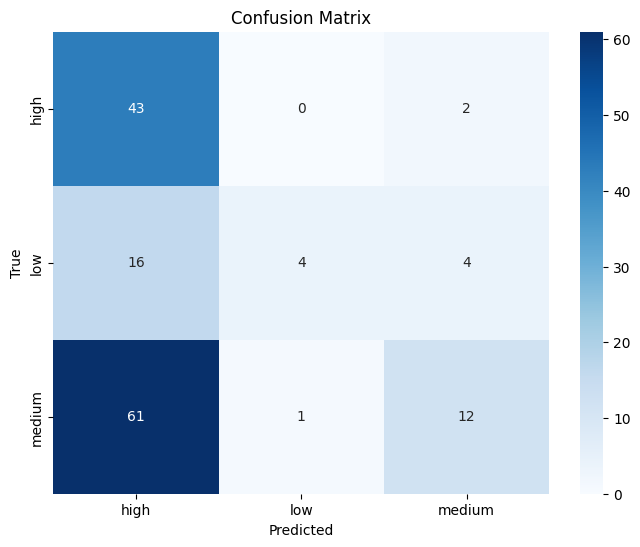

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# Assuming y_true and y_pred_new are already defined
# Encode labels
label_encoder = LabelEncoder()
y_true_encoded = label_encoder.fit_transform(y_true)
y_pred_new_encoded = label_encoder.transform(y_pred)

# Print classification report
print(classification_report(y_true_encoded, y_pred_new_encoded))

# Generate confusion matrix
cm = confusion_matrix(y_true_encoded, y_pred_new_encoded)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()